# Recurrent Neural Networks

Welcome to the Paper implementation section. This is the first notebook, I will be implementing a simple RNN. It has been made much easier for us by the `nn.RNN` abstraction provided by PyTorch. We will be using that to create a simple `Spam Classifier`. 

The dataset for the following tutorial can be downloaded from Kaggle - [Link](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

Let's get started!

In [2]:
# Importing neccessary libraries
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [3]:
# Setting training device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


We don't have a predefined Dataset object for the Spam Classification Dataset. Before we get to that, we have to understand a few important concepts and implement them. One of these concepts, very critical for us, is tokenizer. It helps us in tokenizing the input, i.e converting the input to some numerical form, usually vectors in a vector space. 

## Looking at the Data - EDA

In [1]:
import pandas as pd
import numpy as np

`ISO-8859-1` is a single byte encoding that can encode the first 256 Unicode characters, it has some latin letters, punctuations etc. It is widely used in Europe and USA, as it supports their language. 

In [2]:
df_train = pd.read_csv("spam.csv", encoding = "ISO-8859-1")
df_train.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [10]:
df_train.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [13]:
uniq_v1 = df_train["v1"].unique()
print(uniq_v1)

['ham' 'spam']


> Note: We can use Ordinal encoding when there exists a natural rank ordering. If that doesn't exist, then go for One Hot Encoding. 

We don't have a natural rank ordering, hence we are going to One Hot Encode our data. 

We can create a custom One Hot encoder or use pre existing encoder. For the sake of self-reliance, I am going to create a custom One Hot encoder.

In [65]:
def OneHotEncoder(df, df_column):
    uniq_values = df_train[df_column].unique()
    number_of_features = len(uniq_values)
    main_dict = {}
    zero_list = np.zeros(len(df))
    for num, val in enumerate(uniq_values):
        # If you have main_dict[val] = zero_list, then you invariably create a reference and this would mess up the One Hot Encoding
        main_dict[val] = list(zero_list)
    for num, record in enumerate(df_train[df_column]):
        main_dict[str(record)][num] = 1.0
    df_one_hot = pd.DataFrame.from_dict(main_dict)
    frames = [df, df_one_hot]
    df_result = pd.concat(frames,axis=1, join='inner')
    return df_result


In [71]:
df_result = OneHotEncoder(df_train, "v1")
print(df_result.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  ham  spam  
0        NaN        NaN  1.0   0.0  
1        NaN        NaN  1.0   0.0  
2        NaN        NaN  0.0   1.0  
3        NaN        NaN  1.0   0.0  
4        NaN        NaN  1.0   0.0  


In [72]:
import matplotlib.pyplot as plt

First, we are going to visually see the ratio between `ham` and `spam`. We can do this using Pie Chart. We are using `plt.pie` function. 

The first argument is the row value, `v1` in our case, split along different categories. 

In [76]:
df_result["v1"].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

We can now collect the labels from the dataframe row using the `unique()` method and converting it into a list. We will use `plt.show()` to visualize the image in a neat manner. 

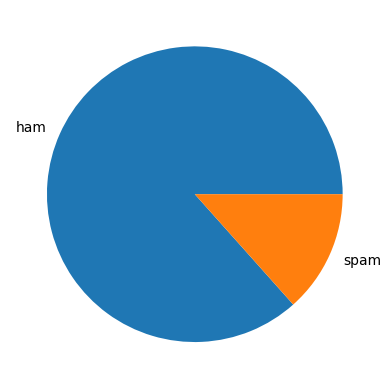

In [77]:
plt.pie(df_result["v1"].value_counts(), labels= df_result["v1"].unique().tolist())
plt.show()

We are still missing a crucial information. We would like to see the ratio (percentage) on the pie chart. All we need to do is add `autopct` which will add numeric values to the pies. 

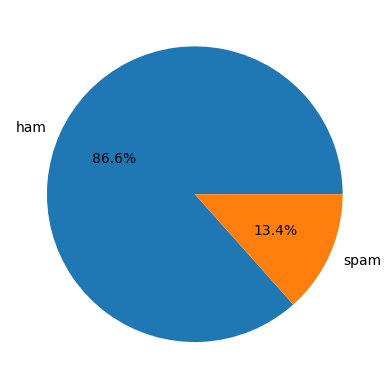

In [78]:
plt.pie(df_result["v1"].value_counts(), labels= df_result["v1"].unique().tolist(), autopct= '%1.1f%%')
plt.show()

The next few steps can be:
1. Character Count
2. Word Count
3. Mean Word Length
4. Mean Sentence Length
5. Term Frequency Analysis
6. Frequency of N-grams

I am done for the day with EDA but I will be slowly working on this. 